## Transfer learning for CIFAR10 dataset

This notebook is to train a classifier for CIFAR10 dataset using transfer learning.
The steps that are done here:
- downloading and loading the dataset,
- showing sample images for each category,
- training simple classifier based on HOG features extracted from images - this serves as a benchmark for further classifiers,
- extracting features using ResNet50 network without the last layer,
- visualization of these features using dimensionality reduction techniques (PCA, t-SNE),
- choosing optimal hyper parameters for LinearSVM, SVM and GradientBoostingClassifier using GridSearch and then checking the accuracy for the test set

### Download CIFAR10 dataset

In [0]:
from urllib.request import urlretrieve
from urllib.parse import urlparse
import os

cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
cifar10_archive_file = os.path.basename(urlparse(cifar10_url).path)

urlretrieve(cifar10_url, cifar10_archive_file)

('cifar-10-python.tar.gz', <http.client.HTTPMessage at 0x1ac796fb320>)

### Extract archive file

In [0]:
import tarfile

def extract_archive_file(archive_file):
  with tarfile.open(archive_file) as file:
    file.extractall()
    
extract_archive_file(cifar10_archive_file)

### Load data from archive file

In [0]:
import numpy as np
import os

cifar_path = "cifar-10-batches-py"

def load_data(cifar_path):
  data = load_batches(cifar_path)
  test_data = load_test_batch(cifar_path)
  return data, test_data 

def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

def load_batches(cifar_path):
  batch_names = [ "data_batch_{}".format(i) for i in range(1, 6) ]
  data_batches = [ load_batch(cifar_path, batch_name) for batch_name in batch_names ]
  data = [ data for (data, label) in data_batches ]
  labels = [ label for (data, label) in data_batches ]
  return np.concatenate(data), np.concatenate(labels)

def load_test_batch(cifar_path):
  return load_batch(cifar_path, "test_batch");

def load_batch(cifar_path, batch_name):
  data_batch = unpickle(os.path.join(cifar_path, batch_name))
  return data_batch[b'data'], data_batch[b'labels']

(X_train, y_train), (X_test, y_test) = load_data(cifar_path)


Load labels

In [0]:
labels_bytes = unpickle(os.path.join(cifar_path, "batches.meta"))
labels = [ str(label, 'utf-8') for label in labels_bytes[b'label_names'] ]

### Reshape samples

Make 32x32x3 images from 3072 long feature vector, to be able to show it, feed it into HOG and Resnet50

In [0]:
def reshape(image):
  red_channel = image[0:1024].reshape(32, 32)
  green_channel = image[1024:2048].reshape(32, 32)
  blue_cannel = image[2048:3072].reshape(32, 32)
  return np.dstack((red_channel, green_channel, blue_cannel))

In [0]:
X_train_reshaped = np.asarray([reshape(x) for x in X_train ])
X_test_reshaped = np.asarray([reshape(x) for x in X_test ])

### Show random images from each category

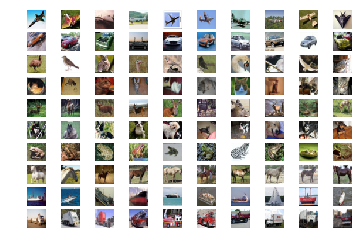

In [0]:
import matplotlib.pyplot as plt

number_of_classes = 10
number_of_examples = 10

def get_random_subsets_by_class(X, y, number_of_classes, number_of_examples):
  data_by_class = [ X[y == class_number] for class_number in range(number_of_classes) ]
  return [ get_random_subset(data, number_of_examples) for data in data_by_class ]
  
def get_random_subset(data, number_of_examples):
  indices = np.random.choice(range(data.shape[0]), number_of_examples)
  return data[indices]

random_subset_by_class = get_random_subsets_by_class(
        X_train_reshaped,
        y_train,
        number_of_classes,
        number_of_examples)

plt.figure(figsize=(8, 8))
fig, axes = plt.subplots(nrows=number_of_classes, ncols=number_of_examples)
for i in range(number_of_examples):
    for j in range(number_of_classes):
        axes[i, j].imshow(random_subset_by_class[i][j])
        axes[i, j].set_axis_off()

### Benchmark using hog feature extractor

This is to see what is possible to achieve without Deep Neural Networks.

#### Extract hog features

In [0]:
from skimage.feature import hog
from skimage import color
from matplotlib.pyplot import imshow

def get_hog(image):
  grey_image = color.rgb2gray(image)
  return hog(grey_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

In [0]:
X_train_hog = np.asarray([ get_hog(x) for x in X_train_reshaped ])
X_test_hog = np.asarray([ get_hog(x) for x in X_test_reshaped ])

#### Show features with reduced dimensionality

Use PCA and then t-SNE, more details in the part with ResNet50 features

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_hog_pca_10 = PCA(n_components=10).fit_transform(X_train_features[0:10000])
X_hog_tsne = TSNE(n_components=2).fit_transform(X_hog_pca_10)

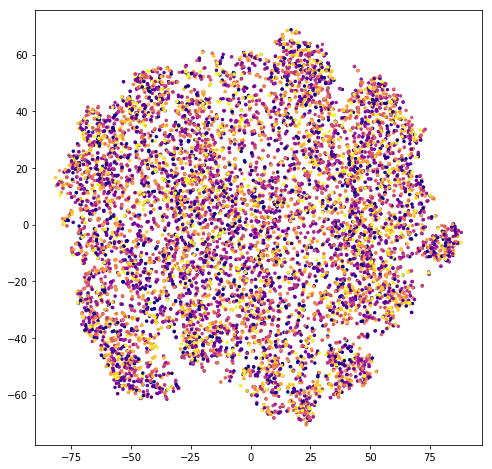

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(X_hog_tsne[:, 0], X_hog_tsne[:, 1], c=y_train[0:10000], s=6, cmap='plasma')

The categories are not easily separable on the plot above.

#### Find best C parameter for Linear SVM model

Use only 5000 samples to make the process quicker

In [0]:
parameters = {'C': np.logspace(-4, 0, 13)}

svc_hog_model = svm.LinearSVC()
grid_search = GridSearchCV(svc_hog_model, parameters, cv=3, n_jobs=8)
grid_search.fit(X_train_hog[0:5000], y_train[0:5000]) 

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': array([1.00000e-04, 2.15443e-04, 4.64159e-04, 1.00000e-03, 2.15443e-03,
       4.64159e-03, 1.00000e-02, 2.15443e-02, 4.64159e-02, 1.00000e-01,
       2.15443e-01, 4.64159e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

LinearSVC(C=0.00046415888336127773, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
0.4382


Best C=0.00046415888336127773

#### Train linear SVM model on the features

In [0]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svc_model = svm.LinearSVC(C=0.0004642)
svc_model.fit(X_train_hog, y_train) 

y_pred = svc_model.predict(X_test_hog)
accuracy_score(y_test, y_pred)

0.482

The benchmark above gave 0.482 accuracy on the test set.

### Extract features using ResNet50

Prepare data to be fed into resnet: resize it to the minimal input size of 200x200 pixels

In [0]:
import scipy

def resize_to_200_200(img):
  return scipy.misc.imresize(img, (200, 200, 3))

X_train_200 = np.asarray([resize_to_200_200(x) for x in X_train_reshaped ])
X_test_200 = np.asarray([resize_to_200_200(x) for x in X_test_reshaped ])


c:\users\pawel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


#### Initialize ResNet50 model

Use keras implementation without the last layer

In [0]:
from keras import applications

resnet50 = applications.resnet50.ResNet50(
    weights='imagenet',                                   
    include_top=False,
    input_shape=(200, 200, 3))

c:\users\pawel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Extract features

In [0]:
X_train_features = resnet50.predict(X_train_200)
X_test_features  = resnet50.predict(X_test_200)

#### Save features to files

Extracting features was very time consuming, so it is a good idea to save them.

In [0]:
import pickle

def save(file_name, data):
    with open(file_name, 'wb') as file:
      pickle.dump(data, file)

save('x_train_features_resnet.pickle', X_train_features)
save('y_train_resnet.pickle', y_train)
save('x_test_features_resnet.pickle', X_test_features)
save('y_test_resnet.pickle', y_test)

#### Load features from files

In [0]:
import pickle

def load(file_name):
    with open(file_name, 'rb') as file:
      return pickle.load(file)
    
X_train_features = load('x_train_features_resnet.pickle')
y_train = load('y_train_resnet.pickle')
X_test_features = load('x_test_features_resnet.pickle')
y_test = load('y_test_resnet.pickle')

Flatten the features (from 1x1x2048 to 2048)

In [0]:
import numpy as np

X_train_features = np.asarray([ x.ravel() for x in X_train_features])
X_test_features = np.asarray([ x.ravel() for x in X_test_features])

### Visualize features using PCA and t-SNE

Use PCA only for 20000 samples

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_2 = pca.fit_transform(X_train_features)

Show explainded variance by the two components

<BarContainer object of 2 artists>

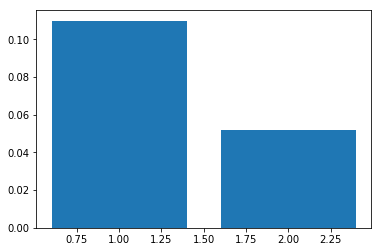

In [0]:
import matplotlib.pyplot as plt

plt.bar(range(1, 3), pca.explained_variance_ratio_)

Plot the components

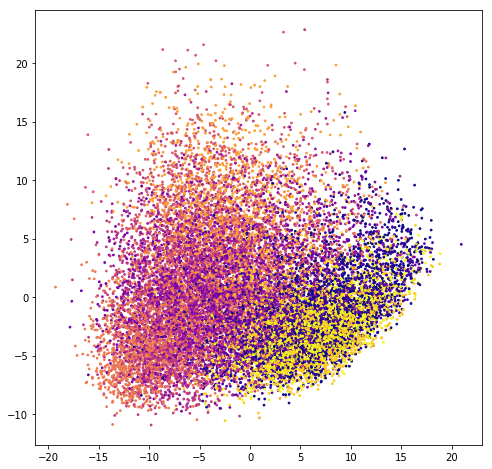

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(
    pca_2[0:20000, 0],
    pca_2[0:20000, 1],
    c=y_train[0:20000],
    s=3,
    cmap='plasma')

The boundaries between classes are not really clear, although it is much better than when using shallow classifier. Let's use t-SNE.

t-SNE won't work efficiently on 50000 samples each with 2048 features, so use PCA first to have 50 features first

In [0]:
pca = PCA(n_components=100)
pca_50 = pca.fit_transform(X_train_features)

In [0]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X_train_features[0:10000])

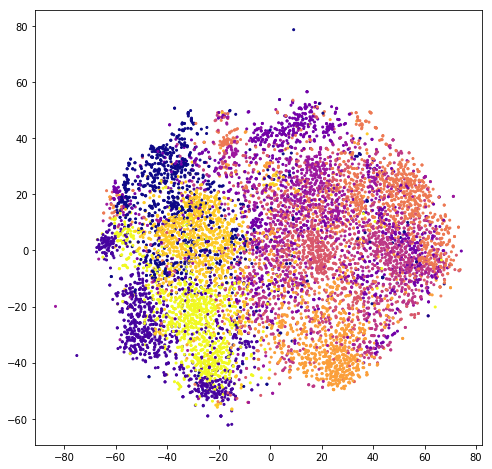

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[0:10000], s=4, cmap='plasma')

t-SNE gives significantly better result - clasifier trained only on these two features could potentially have relatively good accuracy.

### Train SVM classifier on the features

#### Find hyper parameters for Linear SVM

Find best C parameter for Linear SVC model

Notes: 
- the ``np.logspace(-3, -2, 13)`` range is already narrowed down after previous, more broad searches.  
- search on part of the samples (10000), and using 8 cores to speed up the process

In [0]:
parameters = {'C': np.logspace(-3, -2, 13)}

svc_model = svm.LinearSVC(random_state=10)
grid_search = GridSearchCV(svc_model, parameters, cv=5, n_jobs=8)
grid_search.fit(X_train_features[0:10000], y_train[0:10000]) 


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=10, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': array([0.001  , 0.00121, 0.00147, 0.00178, 0.00215, 0.00261, 0.00316,
       0.00383, 0.00464, 0.00562, 0.00681, 0.00825, 0.01   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

LinearSVC(C=0.0014677992676220691, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=10,
     tol=0.0001, verbose=0)
0.8356


Best C = 0.0017782794100389228

#### Find hyper parameters for SVM with RBF kernel

Find best C and gamma parameters for SVM classifier with RBF kernel using GridSearchCV. This is done for a small subset of samples and run in parallel.

Notes: 
- the ``np.logspace(0, 1, 6)`` and ``np.logspace(-4, -2, 7)`` ranges are already narrowed down after previous, more broad searches,
- search on part of the samples (10000), and using 8 cores to speed up the process

In [0]:
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = { 'C': np.logspace(0, 1, 5), 'gamma': np.logspace(-4, -2, 7) }

svc_model = svm.SVC(random_state=10)
grid_search = GridSearchCV(svc_model, parameters, cv=5, n_jobs=8)
grid_search.fit(X_train_features[0:5000], y_train[0:5000]) 


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=10, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': array([ 1.     ,  1.77828,  3.16228,  5.62341, 10.     ]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

SVC(C=5.623413251903491, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.002154434690031882,
  kernel='rbf', max_iter=-1, probability=False, random_state=10,
  shrinking=True, tol=0.001, verbose=False)
0.8008


Best found C=5.623413251903491, gamma = 0.002154434690031882

#### Train linear model

Train linear model with C = 0.0031622776601683794 for whole training set

In [0]:
svc_model = svm.LinearSVC(C = 0.0017782794100389228)
svc_model.fit(X_train_features, y_train) 

LinearSVC(C=0.0017782794100389228, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [0]:
y_pred = svc_model.predict(X_test_features)
accuracy_score(y_test, y_pred)

0.8634

Best score: 0.864

#### Train model with RBF kernel

Train SVM with RBF kernel with C = 5.623413251903491 and gamma = 0.002154434690031882 for whole training set

In [0]:
svc_model = svm.SVC(C=5.623413251903491, gamma=0.002154434690031882)
svc_model.fit(X_train_features, y_train)

SVC(C=5.623413251903491, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.002154434690031882,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svc_model.predict(X_test_features)
accuracy_score(y_test, y_pred)

0.8707

Best score: 0.8707

#### Show confusion matrix for best model

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[920,   7,  11,   7,   7,   1,   3,   4,  33,   7],
       [ 11, 937,   0,   4,   1,   1,   3,   1,  12,  30],
       [ 17,   0, 841,  28,  55,  18,  29,   7,   4,   1],
       [  4,   4,  29, 769,  30,  91,  36,  21,   7,   9],
       [ 14,   1,  38,  24, 853,  13,  22,  30,   4,   1],
       [  4,   0,  23, 130,  19, 788,   9,  22,   4,   1],
       [  6,   0,  21,  21,  20,  12, 914,   1,   3,   2],
       [ 16,   2,  16,  29,  31,  30,   4, 867,   4,   1],
       [ 40,  13,   6,  10,   4,   0,   1,   2, 918,   6],
       [ 23,  55,   1,   3,   1,   2,   2,   1,  12, 900]], dtype=int64)

It seems that cats are often recognized as dogs but birds are never confused with cars.

#### Gradient boosting 

Try GradientBoostingClassifier to see if it is possible to easily achieve similar results as with SVM.

Find out if for 0.1 learning rate the optimal number of estimators is not tool high for my computer's horsepower. 

In [0]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV

parameters = { 'n_estimators': np.arange(10, 58, 8) }

gb_model = GradientBoostingClassifier(random_state=10, learning_rate=0.1)

grid_search = GridSearchCV(gb_model, parameters, cv=5, n_jobs=8)
grid_search.fit(X_train_features[0:5000], y_train[0:5000]) 

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_estimators': array([10, 18, 26, 34, 42, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)
0.7286


It seems that more than 50 estimators might be needed for 0.1 learning rate. Let's increase the learning rate to 0.2, because with higher number of estimators, training will never finish on my computer.

In [0]:
parameters = { 'n_estimators': np.arange(10, 58, 8) }

gb_model = GradientBoostingClassifier(random_state=10, learning_rate=0.2)

grid_search = GridSearchCV(gb_model, parameters, cv=5, n_jobs=8)
grid_search.fit(X_train_features[0:5000], y_train[0:5000]) 

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_estimators': array([10, 18, 26, 34, 42, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)
0.7366


0.2 learning rate also needs at least 50 estimators.
Let's use these boosting parameters and search for tree parameters. I will search only for max_depth, again, purely because of resource constrains.

In [0]:
parameters = { 'max_depth': np.arange(3, 10, 2) }

gb_model = GradientBoostingClassifier(
    random_state=10, 
    learning_rate=0.2, 
    n_estimators=50)

grid_search = GridSearchCV(gb_model, parameters, cv=5, n_jobs=8)
grid_search.fit(X_train_features[0:5000], y_train[0:5000]) 

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'max_depth': array([3, 5, 7, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)
0.7366


In [0]:
y_pred = grid_search.best_estimator_.predict(X_test_features)
accuracy_score(y_test, y_pred)

0.715

In [0]:
from sklearn.ensemble import GradientBoostingClassifier 

gb_model = GradientBoostingClassifier(
    random_state=10, 
    learning_rate=0.2, 
    n_estimators=50)

gb_model.fit(X_train_features, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)

In [0]:

y_pred = gb_model.predict(X_test_features)
accuracy_score(y_test, y_pred)

0.7806

The result from GradientBoosting classifier is worse that what was achieved with SVM. However, this doesn't tell that it is worse for this problem, it only means that the hyperparameters were chosen less carefully, due to lack of computer power.

### Summary

- Transfer learning is a useful technique that can be used when dataset is not very large or when available computational power is not great.

- SVC model with RBF kernel used on features extracted from ResNet50 network gave 0.8707 accuracy, significant improvement over benchmark result of 0.482.

- In this work, hyperparameters were chosen based on subset of data, which is undesirable, but allowed me to run it on my local computer. Choosing them on the full set of data could give better results.

- t-SNE dimensionality reduction with PCA for initial reduction gave better results for visualizing than PCA alone.
